In [1]:
import torch
import torch.nn as nn
import torchmetrics

from datetime import date

import sys; sys.path.append("../")
from models.model_SimpleUNet import SimpleUnet

from utils import (
    load_data,
    training_loop,
    TiledMSE,
    data_protocol_bd
)


In [2]:
# define training hyper-parameters 
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 64
num_workers = 6

In [3]:
# define dataset folder 
DATA_FOLDER = '/home/lcamilleri/data/s12_buildings/data_patches/'

In [4]:
# define model & criterion
model =  SimpleUnet(input_dim=10, output_dim=1) 
criterion = nn.MSELoss() 
lr_scheduler = 'cosine_annealing' #'reduce_on_plateau'

In [5]:
# define save folder location
NAME = model.__class__.__name__
OUTPUT_FOLDER = f'trained_models/{date.today().strftime("%d%m%Y")}_{NAME}'
if lr_scheduler is not None:
    OUTPUT_FOLDER = f'trained_models/{date.today().strftime("%d%m%Y")}_{NAME}_{lr_scheduler}'
    if lr_scheduler == 'reduce_on_plateau':
        LEARNING_RATE = LEARNING_RATE / 100000 # for warmup start

In [6]:
# attach model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# create a dataset
# split_percentage defines the % of samples taken from 
# each specified region ... example split_percentage = 0.2 
# will create a training set consisting of only 20% of the 
# images from each region.

x_train, y_train, x_val, y_val, x_test, y_test = data_protocol_bd.protocol_split(folder=DATA_FOLDER, split_percentage=0.2)


In [8]:
# create dataloaders for training
dl_train, dl_val, dl_test = load_data(x_train, y_train, x_val, y_val, x_test, y_test,
                                      with_augmentations=False,
                                      num_workers=num_workers,
                                      batch_size=BATCH_SIZE,
                                      encoder_only=False,
                                      )

In [9]:
# define some torch metrics
wmape = torchmetrics.WeightedMeanAbsolutePercentageError(); wmape.__name__ = "wmape"
mae = torchmetrics.MeanAbsoluteError(); mae.__name__ = "mae"
mse = torchmetrics.MeanSquaredError(); mse.__name__ = "mse"

In [10]:
# run training loop
training_loop(
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        model=model,
        criterion=criterion,
        device=device,
        metrics=[
            mse.to(device),
            wmape.to(device),
            mae.to(device),
        ],
        lr_scheduler=lr_scheduler,
        train_loader=dl_train,
        val_loader=dl_val,
        test_loader=dl_test,
        name=NAME,
        out_folder=OUTPUT_FOLDER,
        predict_func=None,
    )

Starting training...



Epoch 100/100: 100%|█████████████████████████████████████████████████| 222/222 [00:22<00:00, 10.05it/s, loss=0.0187, mse=0.0187, wmape=0.5282, mae=0.0716, val_loss=0.0246, val_mse=0.0246, val_wmape=0.6339, val_mae=0.0761, lr=7.03e-5]


Finished Training. Best epoch:  75

Starting Testing...
Test Accuracy: 0.0236


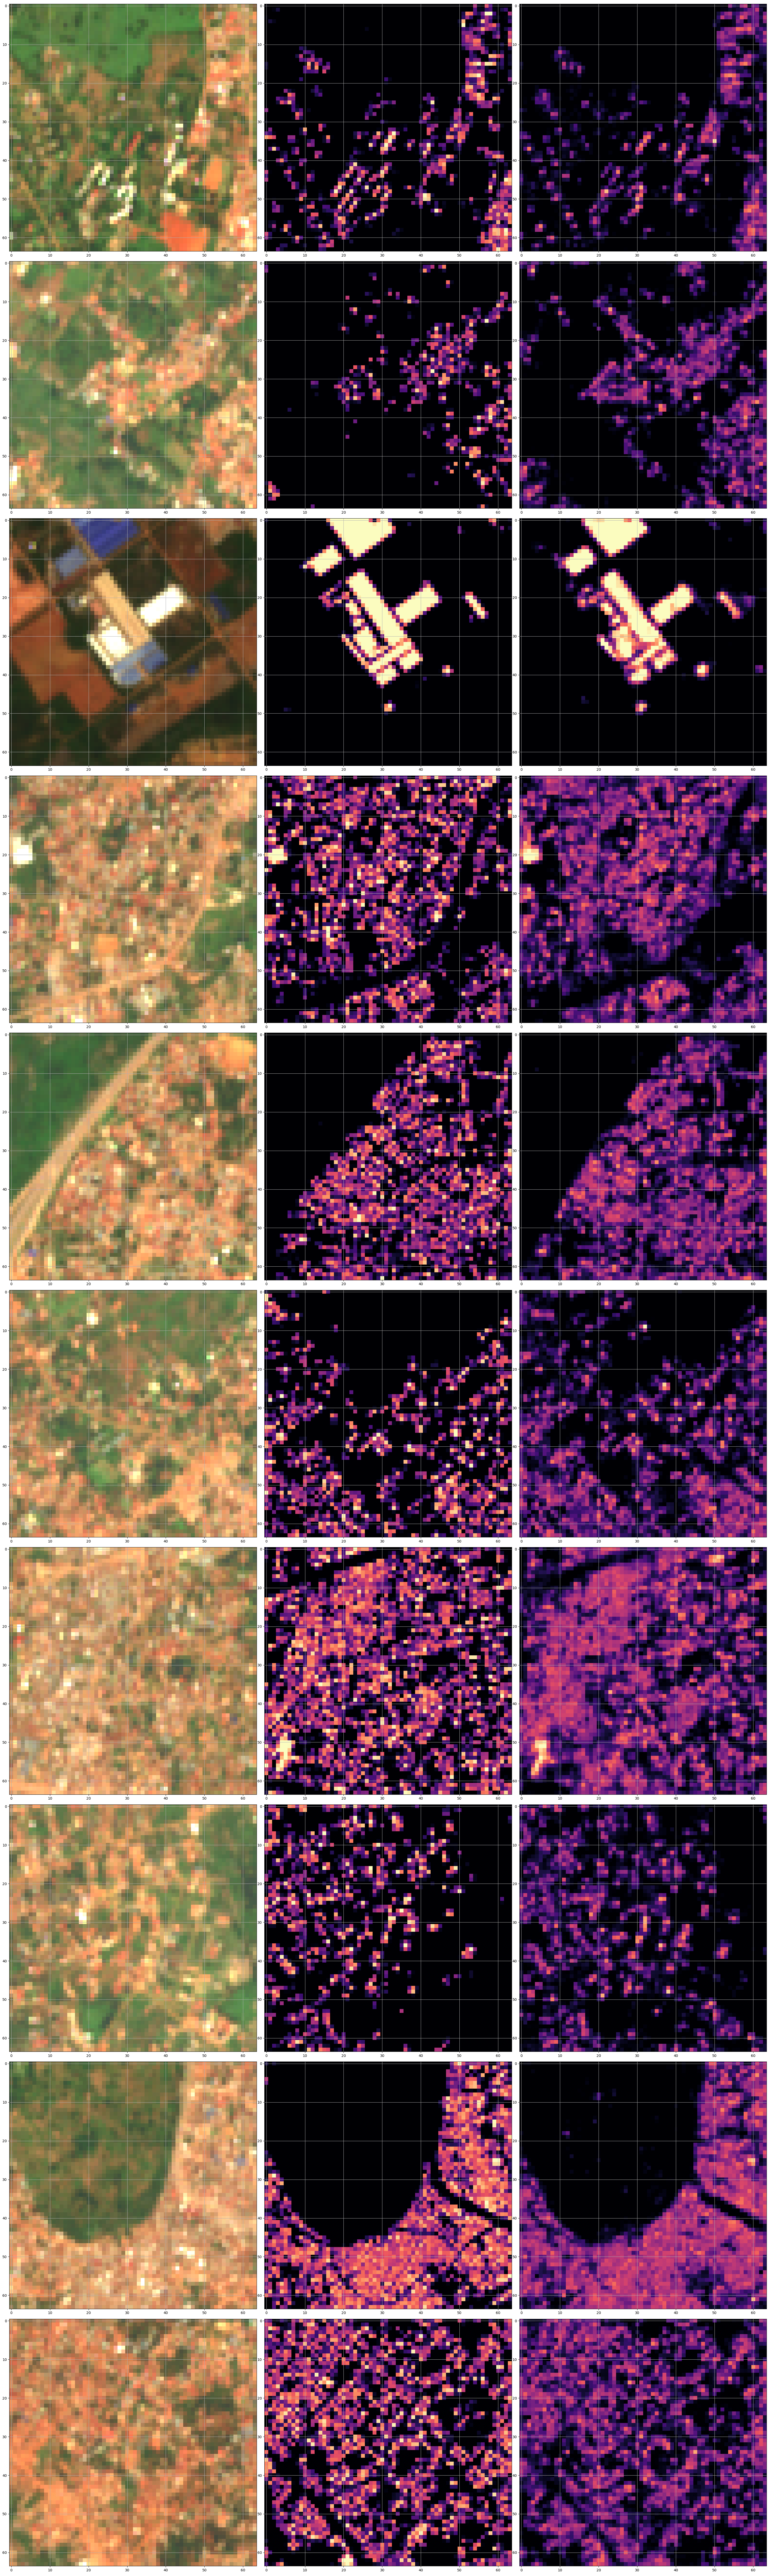

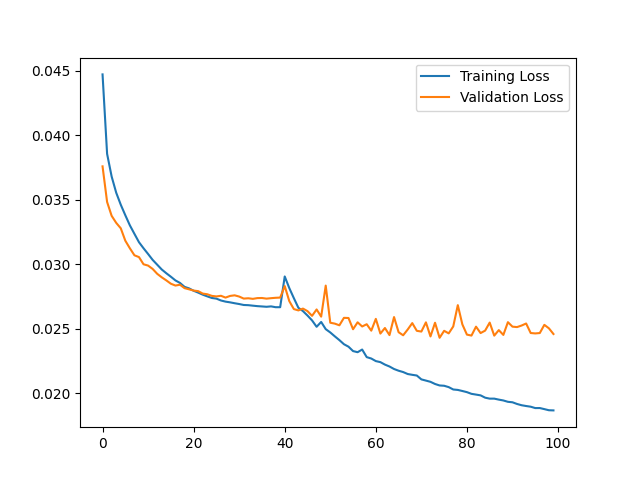

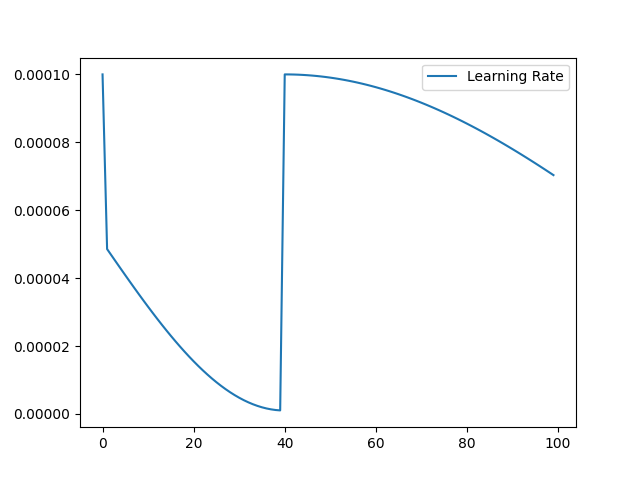

In [11]:
from IPython.display import display, Image
display(Image(filename= f'{OUTPUT_FOLDER}/visualisations/test_pred.png'))
display(Image(filename= f'{OUTPUT_FOLDER}/loss.png'))
display(Image(filename= f'{OUTPUT_FOLDER}/lr.png'))

In [12]:
# Evaluate test metrics
from test_script import evaluate_model
metrics = evaluate_model(model, dl_test, device, OUTPUT_FOLDER, num_visualisations=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 20.02it/s]


In [13]:
metrics

{'test_set': (1664, 64, 64),
 'test_rmse': 0.153630317054135,
 'test_mae': 0.08022006257222249,
 'test_mse': 0.02360227431815404,
 'test_volume_error': 0.011125837560169972,
 'test_accuracy': 0.8592307750995343,
 'test_precision': 0.7080981038222328,
 'test_recall': 0.8629995644796148,
 'threshold_binary_classification': 0.1,
 'baseline_0_mse': 0.0822618156671524,
 'baseline_0_acc': 0.7143237774188702}

In [16]:
#save test metrics
import json
with open(f'{OUTPUT_FOLDER}_metrics.json', 'w') as fp:
    json.dump(metrics, fp)

In [27]:
# Evaluate test metrics on different geographic regions
import buteo as beo
from utils.load_data import callback_decoder
from torch.utils.data import DataLoader

REGIONS_BUILDINGS = ['DNK', 'EGY', 'GHA', 'ISR', 'TZA', 'UGA']
results = {}
for region in REGIONS_BUILDINGS:
    print('Calculating metrics for ',region)
    _, _, _, _, x_test, y_test = data_protocol_bd.protocol_regions(folder=DATA_FOLDER, regions=[region], y='y')
    ds_test = beo.Dataset(x_test, y_test, callback=callback_decoder)
    dl_test = DataLoader(ds_test, batch_size=5, shuffle=False, pin_memory=True, num_workers=num_workers, drop_last=True, generator=torch.Generator(device='cuda'))

    save_path_visualisations = f"{OUTPUT_FOLDER}/visualisations/test_{region}.png"
    metrics = evaluate_model(model, dl_test, device,save_path_visualisations, num_visualisations=5)
    results[region] = metrics
    
print(results)

Calculating metrics for  DNK


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 471/471 [00:02<00:00, 199.89it/s]


Calculating metrics for  EGY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.84it/s]


Calculating metrics for  GHA


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 41.84it/s]


Calculating metrics for  ISR


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.46it/s]


Calculating metrics for  TZA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 136.64it/s]


Calculating metrics for  UGA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 183.80it/s]


{'DNK': {'test_set': (2355, 64, 64), 'test_rmse': 0.15011089023219093, 'test_mae': 0.06705270066635877, 'test_mse': 0.02253327936630087, 'test_volume_error': 0.010538459887170488, 'test_accuracy': 0.8789965457470806, 'test_precision': 0.700223767046004, 'test_recall': 0.8023979356724225, 'threshold_binary_classification': 0.1, 'baseline_0_mse': 0.06719252467155457, 'baseline_0_acc': 0.7763835672107219}, 'EGY': {'test_set': (10, 64, 64), 'test_rmse': 0.3129928909890675, 'test_mae': 0.1749724917113781, 'test_mse': 0.0979645498096943, 'test_volume_error': 0.050208935514092445, 'test_accuracy': 0.736669921875, 'test_precision': 0.4941753525444513, 'test_recall': 0.6833725859632596, 'threshold_binary_classification': 0.1, 'baseline_0_mse': 0.12338630855083466, 'baseline_0_acc': 0.7408447265625}, 'GHA': {'test_set': (45, 64, 64), 'test_rmse': 0.2263494542230119, 'test_mae': 0.14598880211512247, 'test_mse': 0.05123407542705536, 'test_volume_error': 0.037234498891565534, 'test_accuracy': 0.744

In [28]:
#save test metrics
with open(f'{OUTPUT_FOLDER}_metrics_by_region.json', 'w') as fp:
    json.dump(metrics, fp)

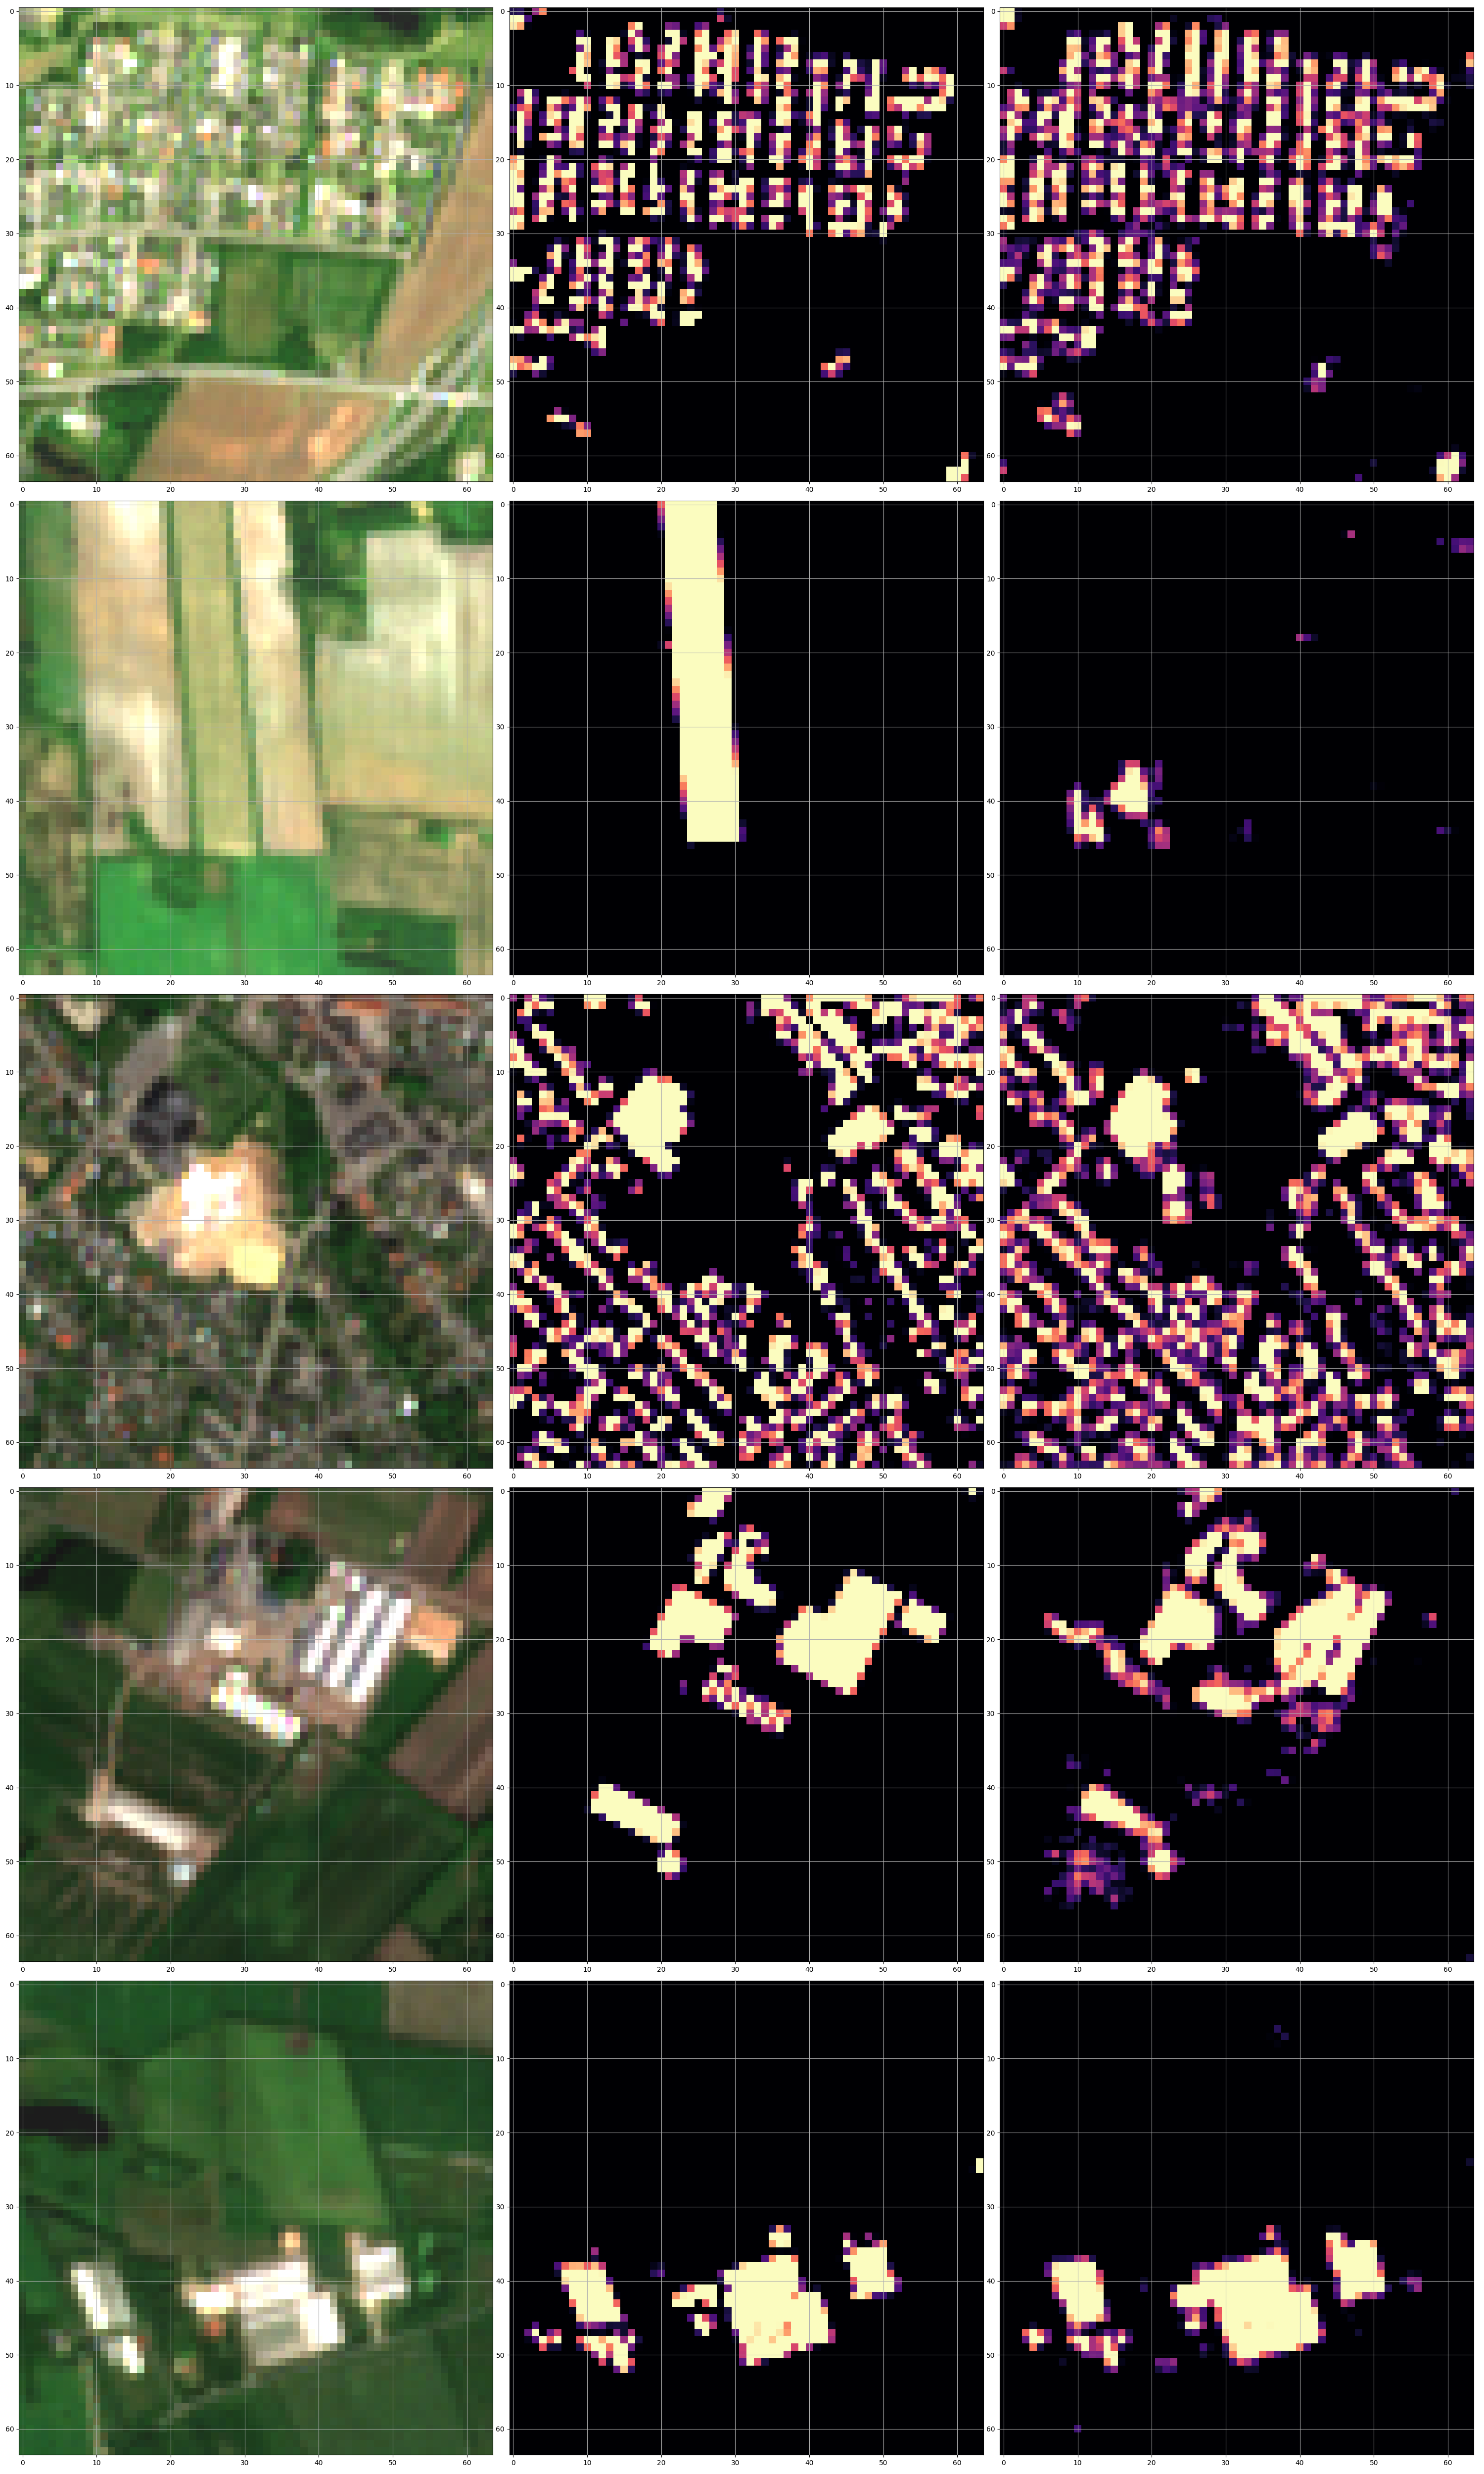

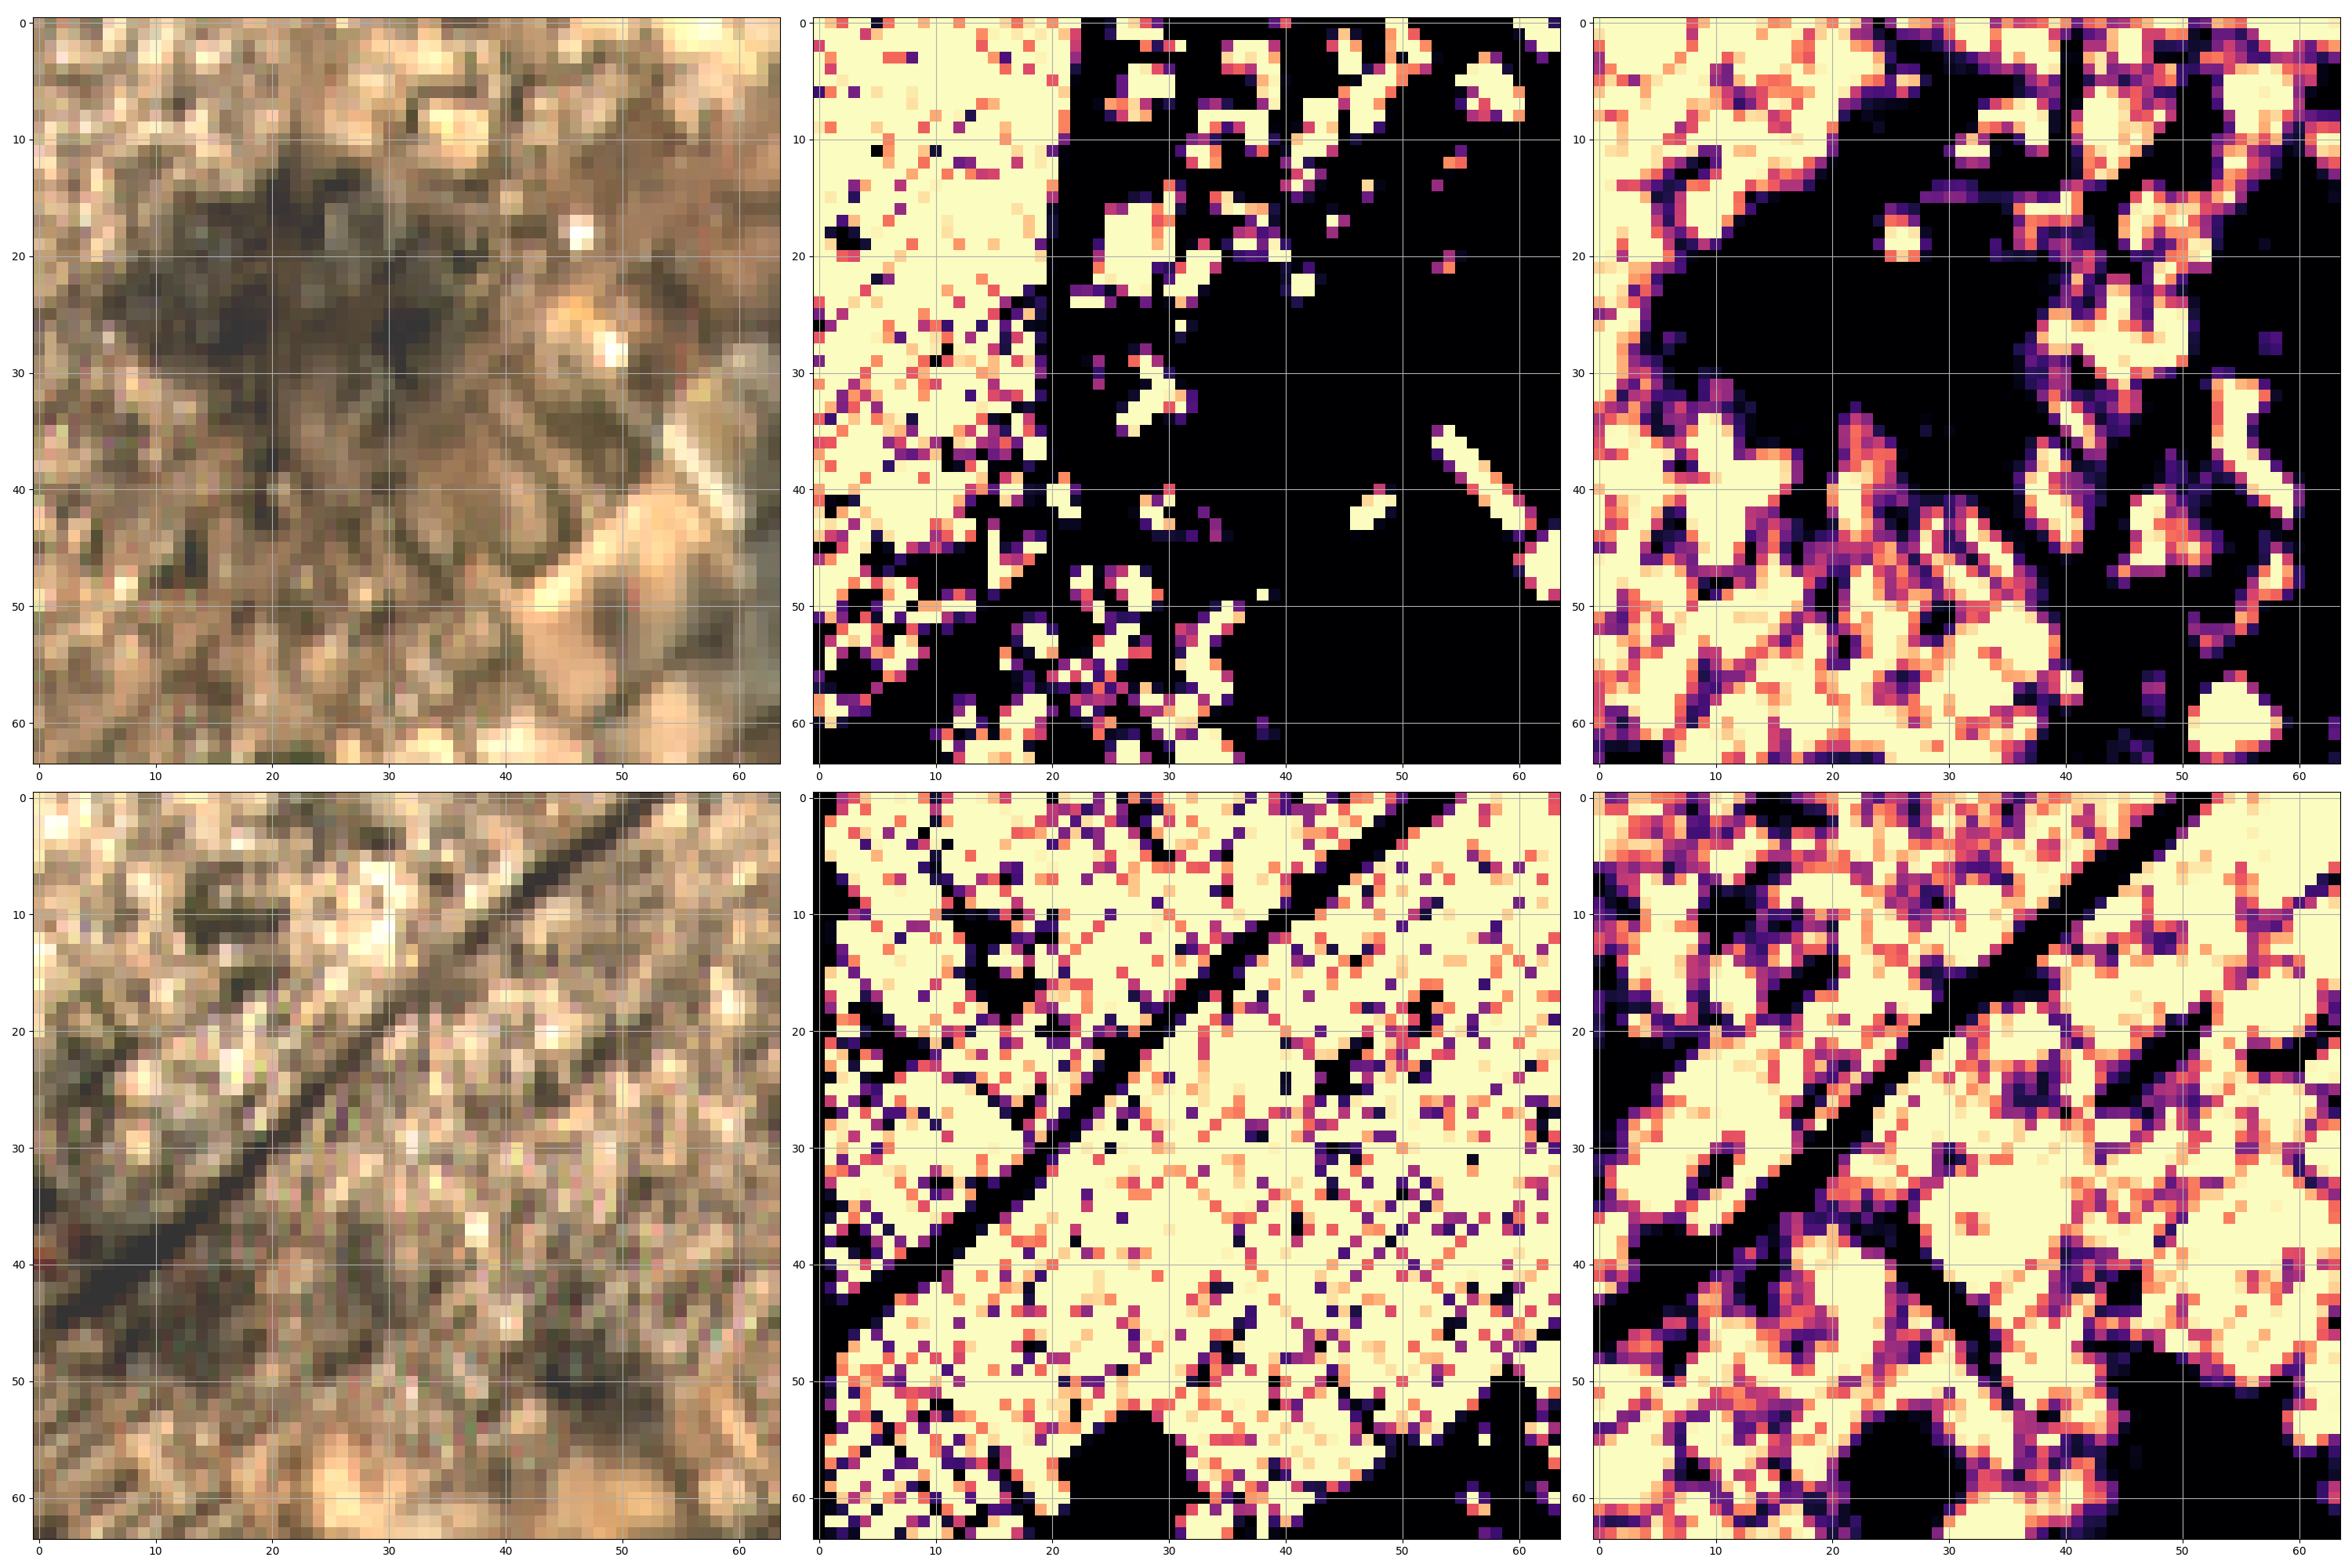

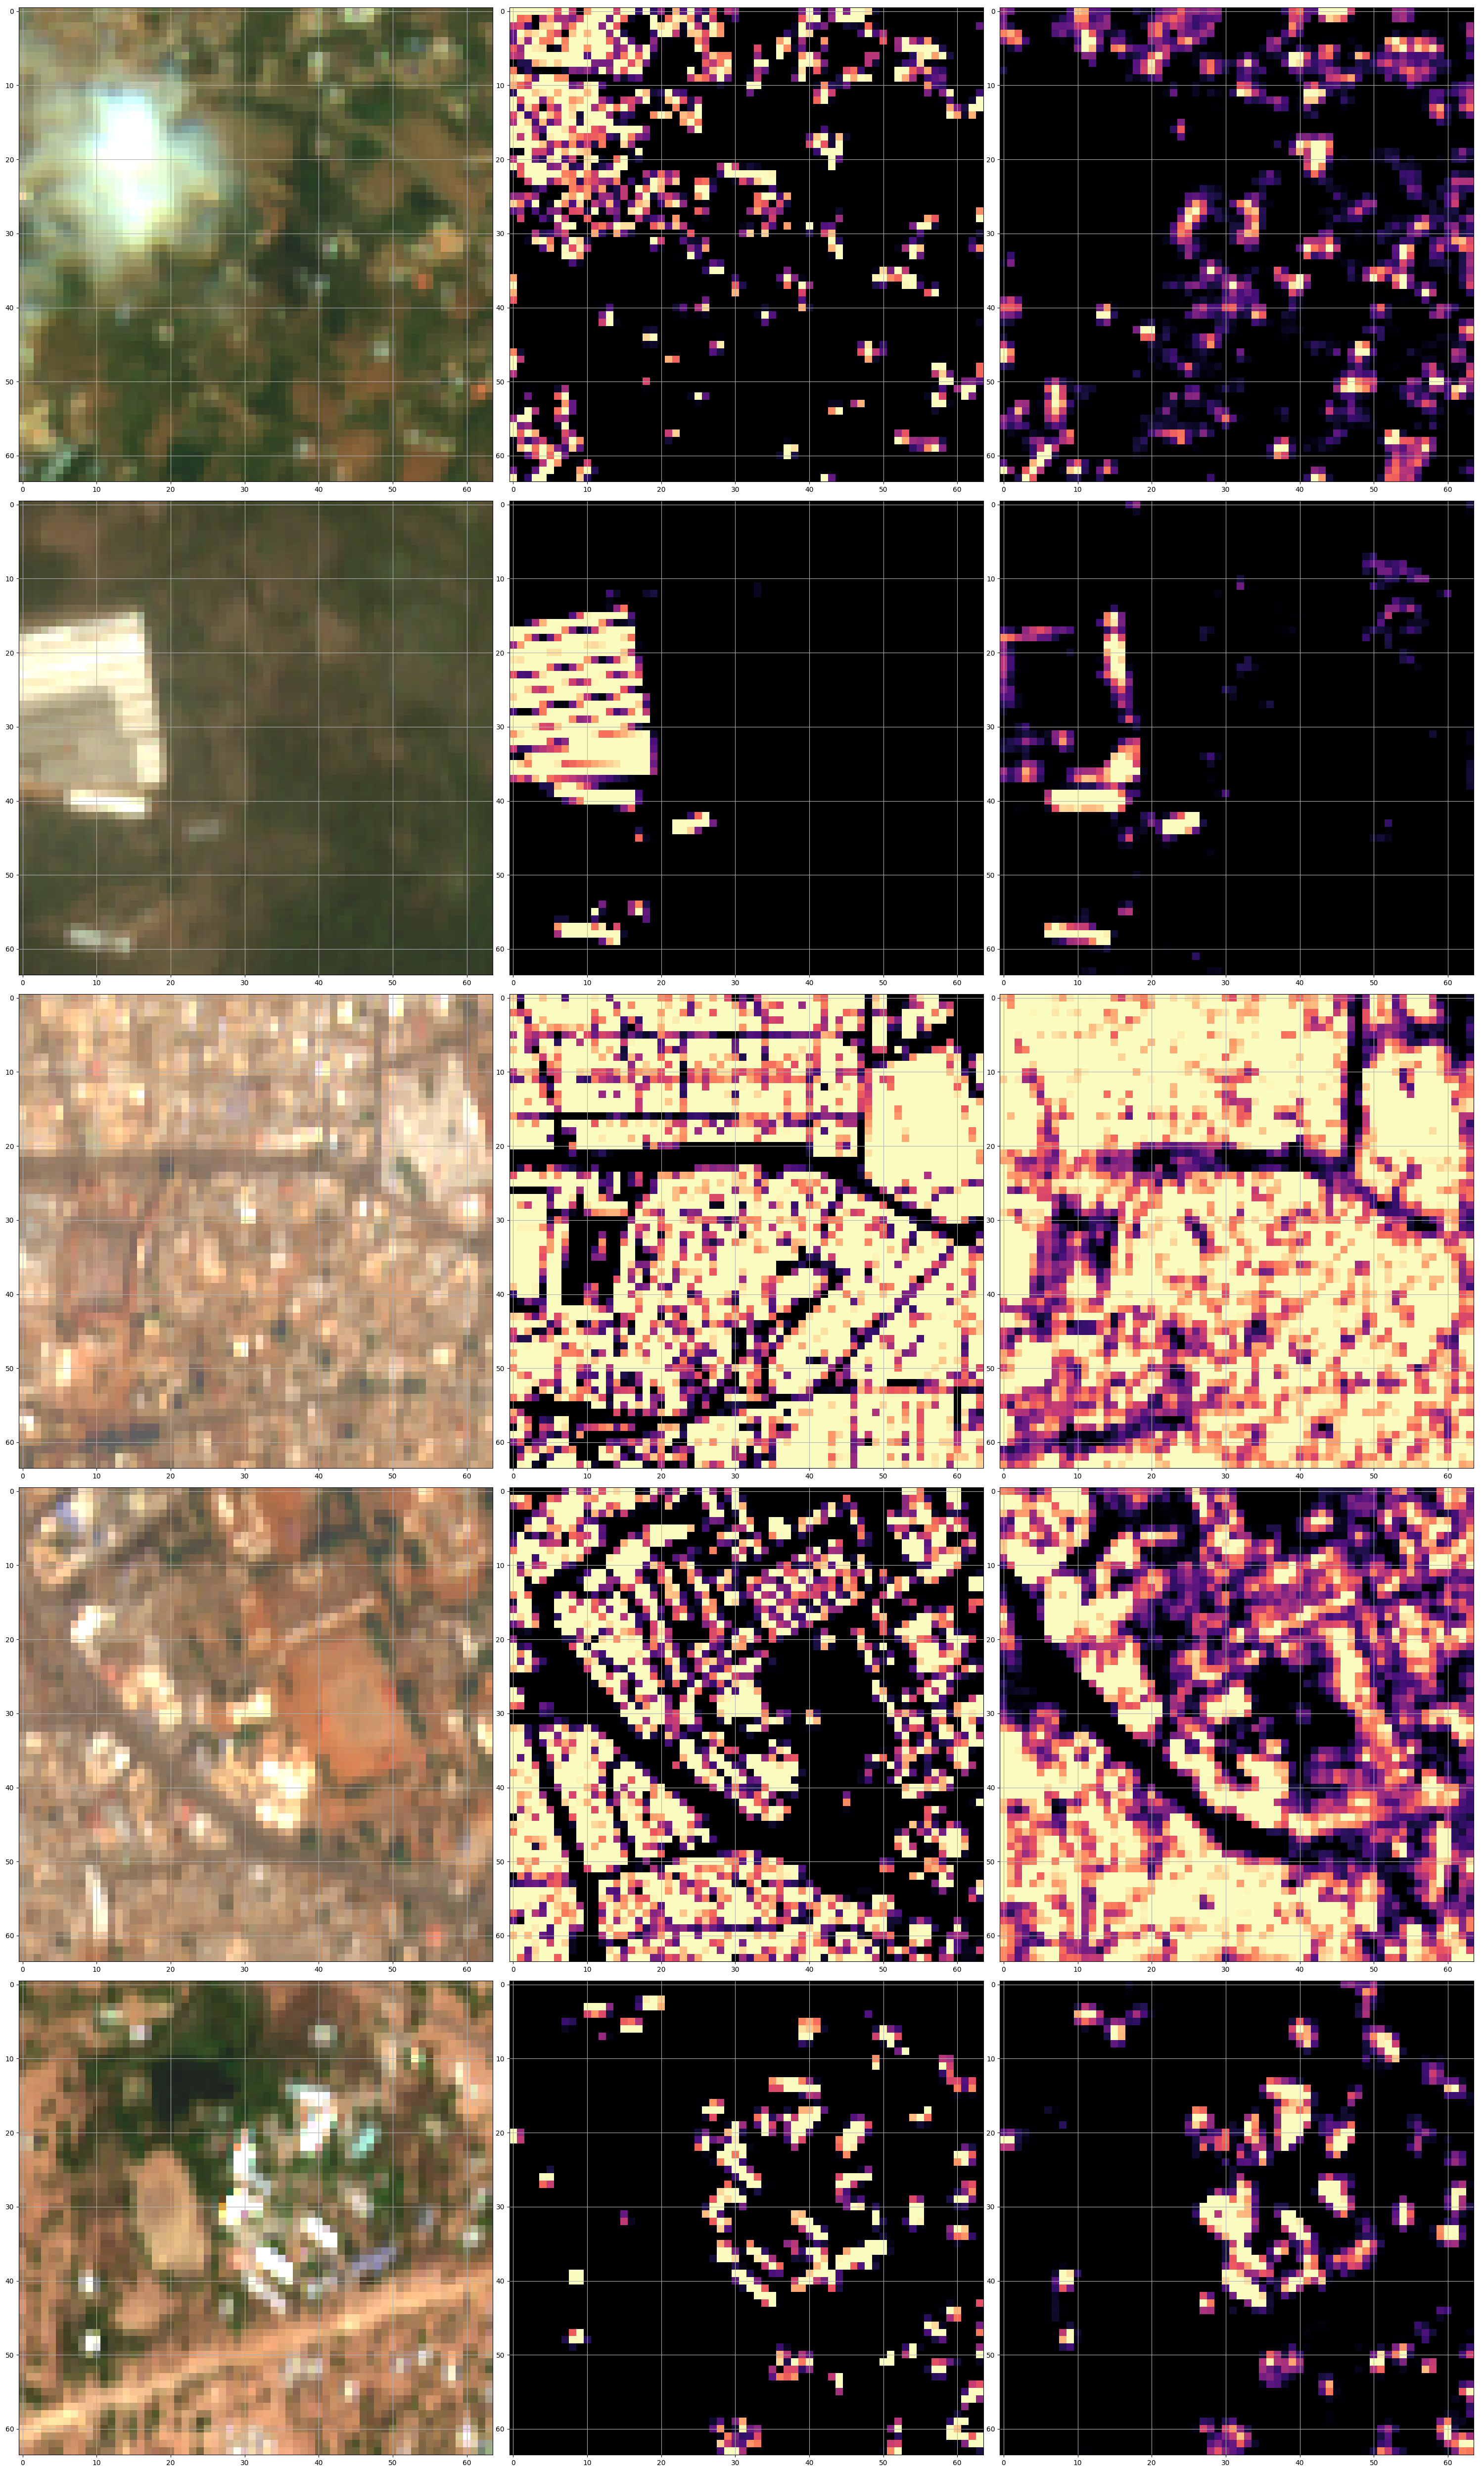

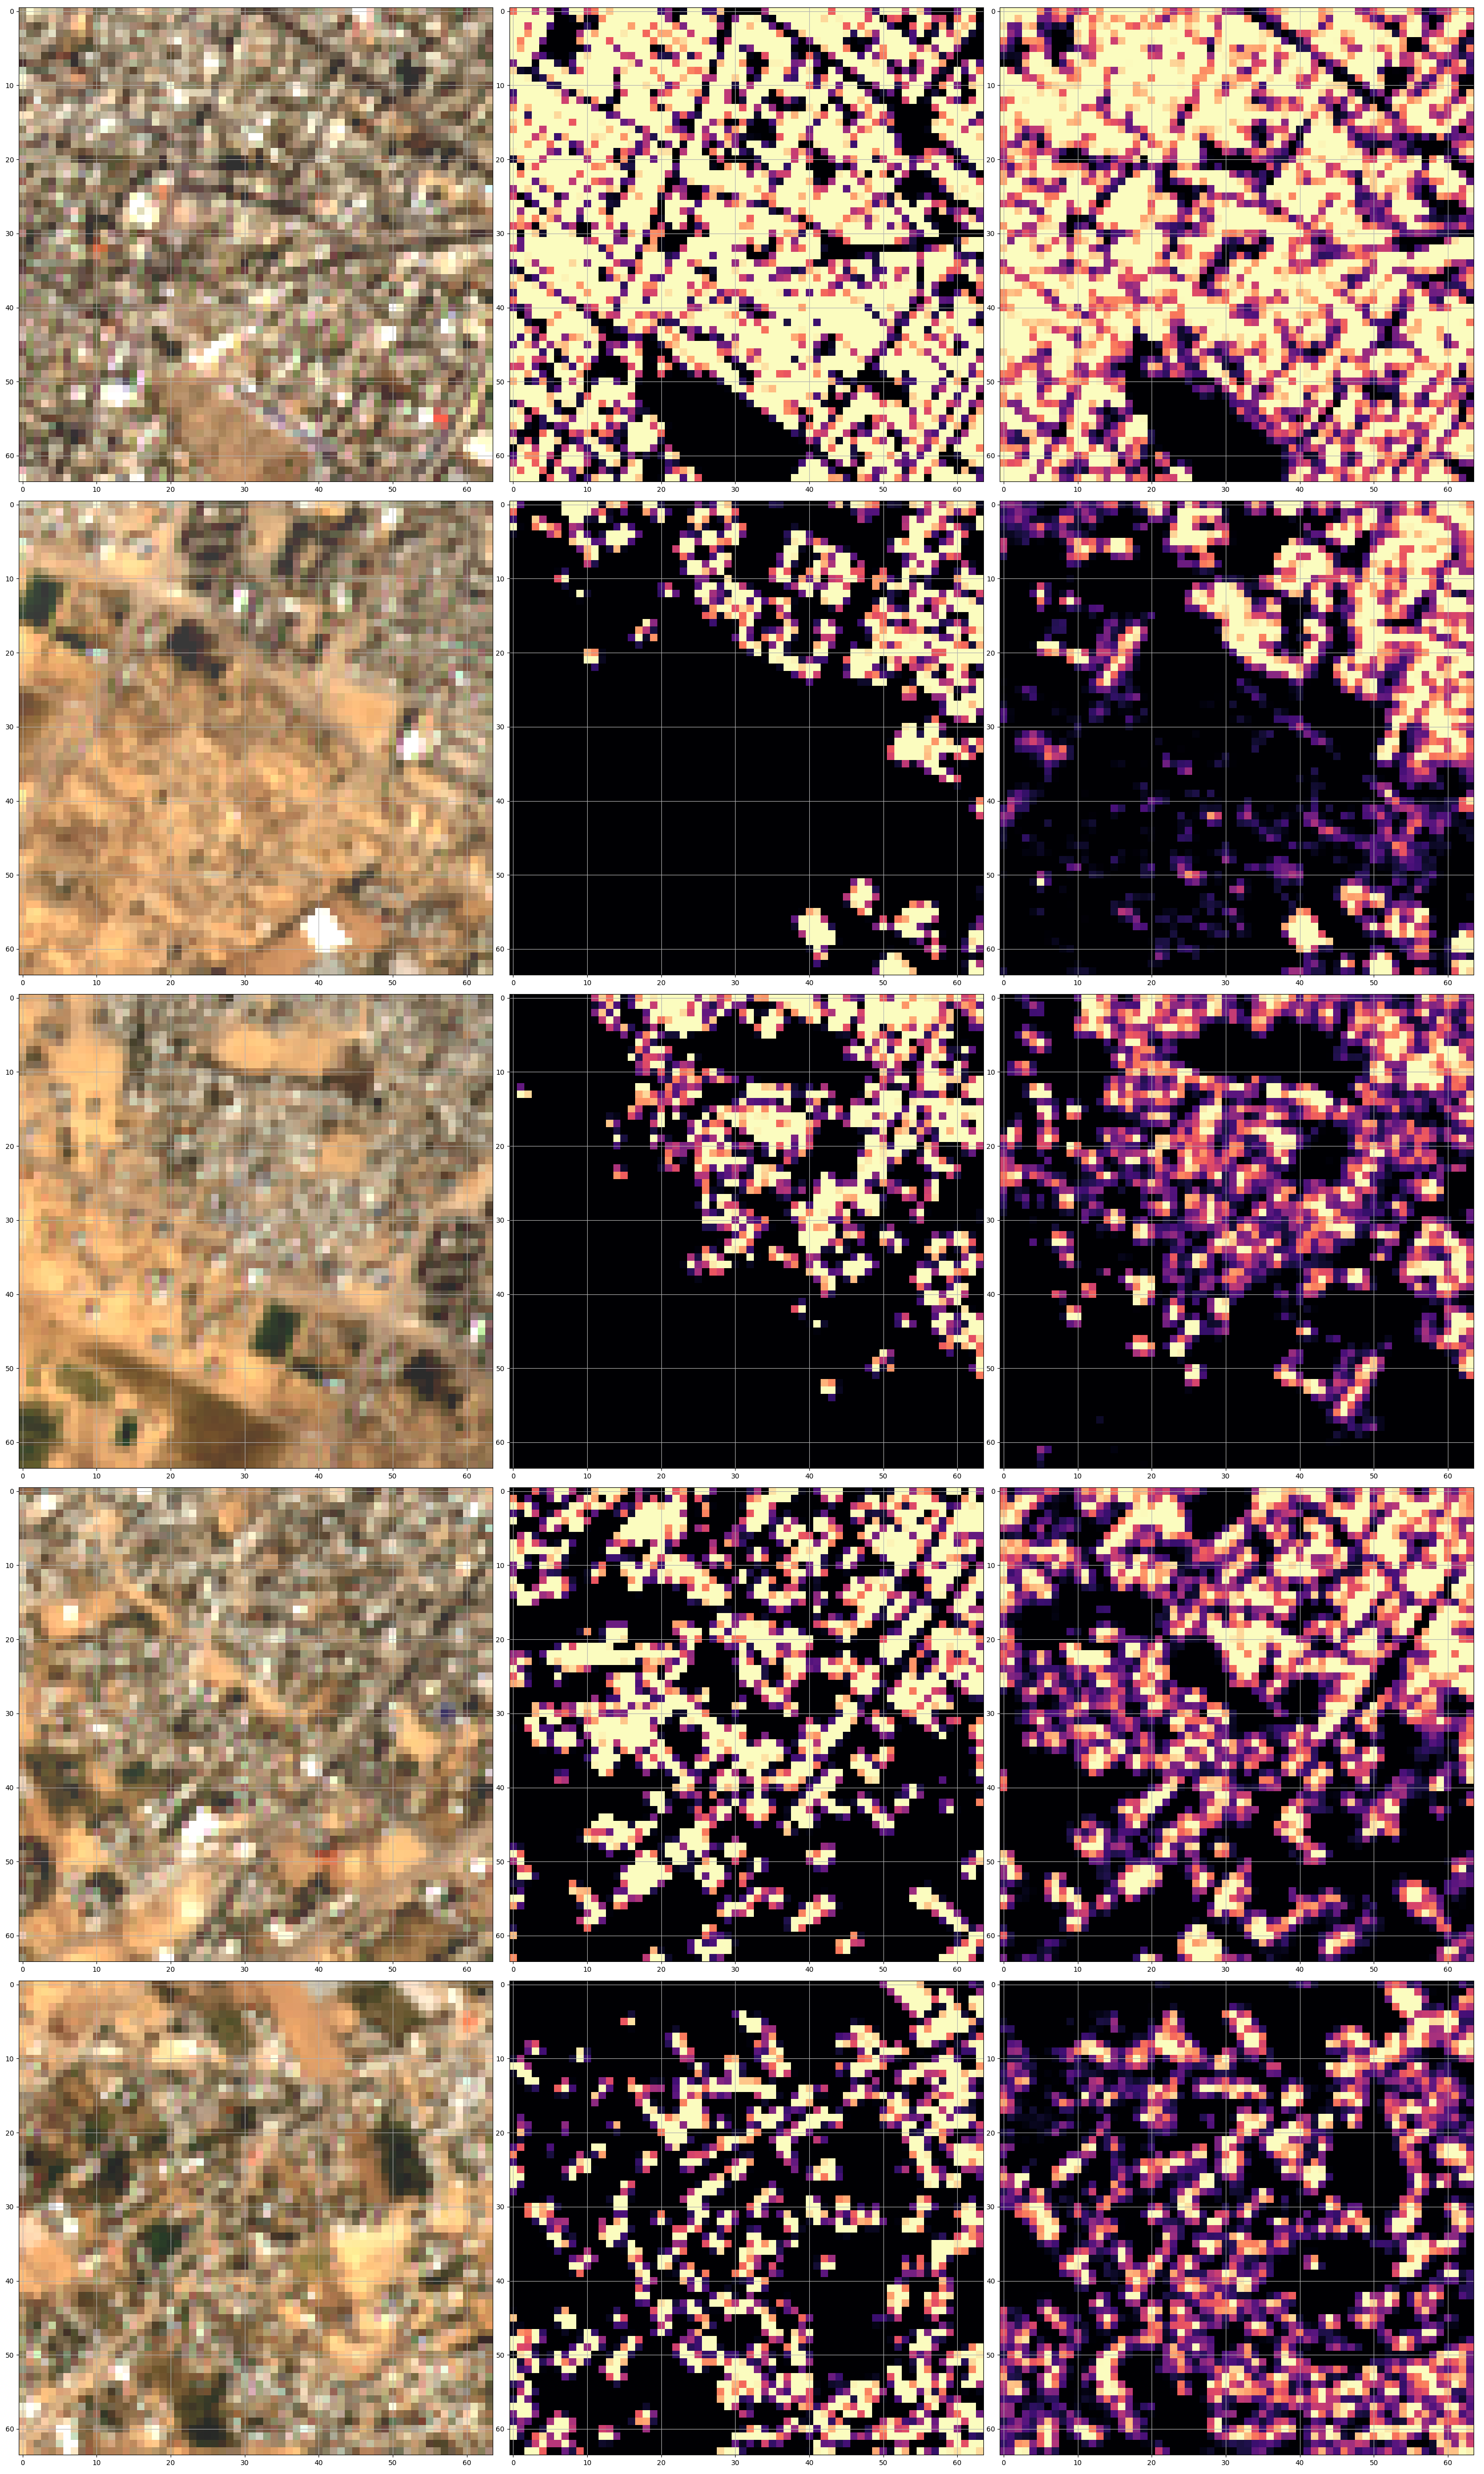

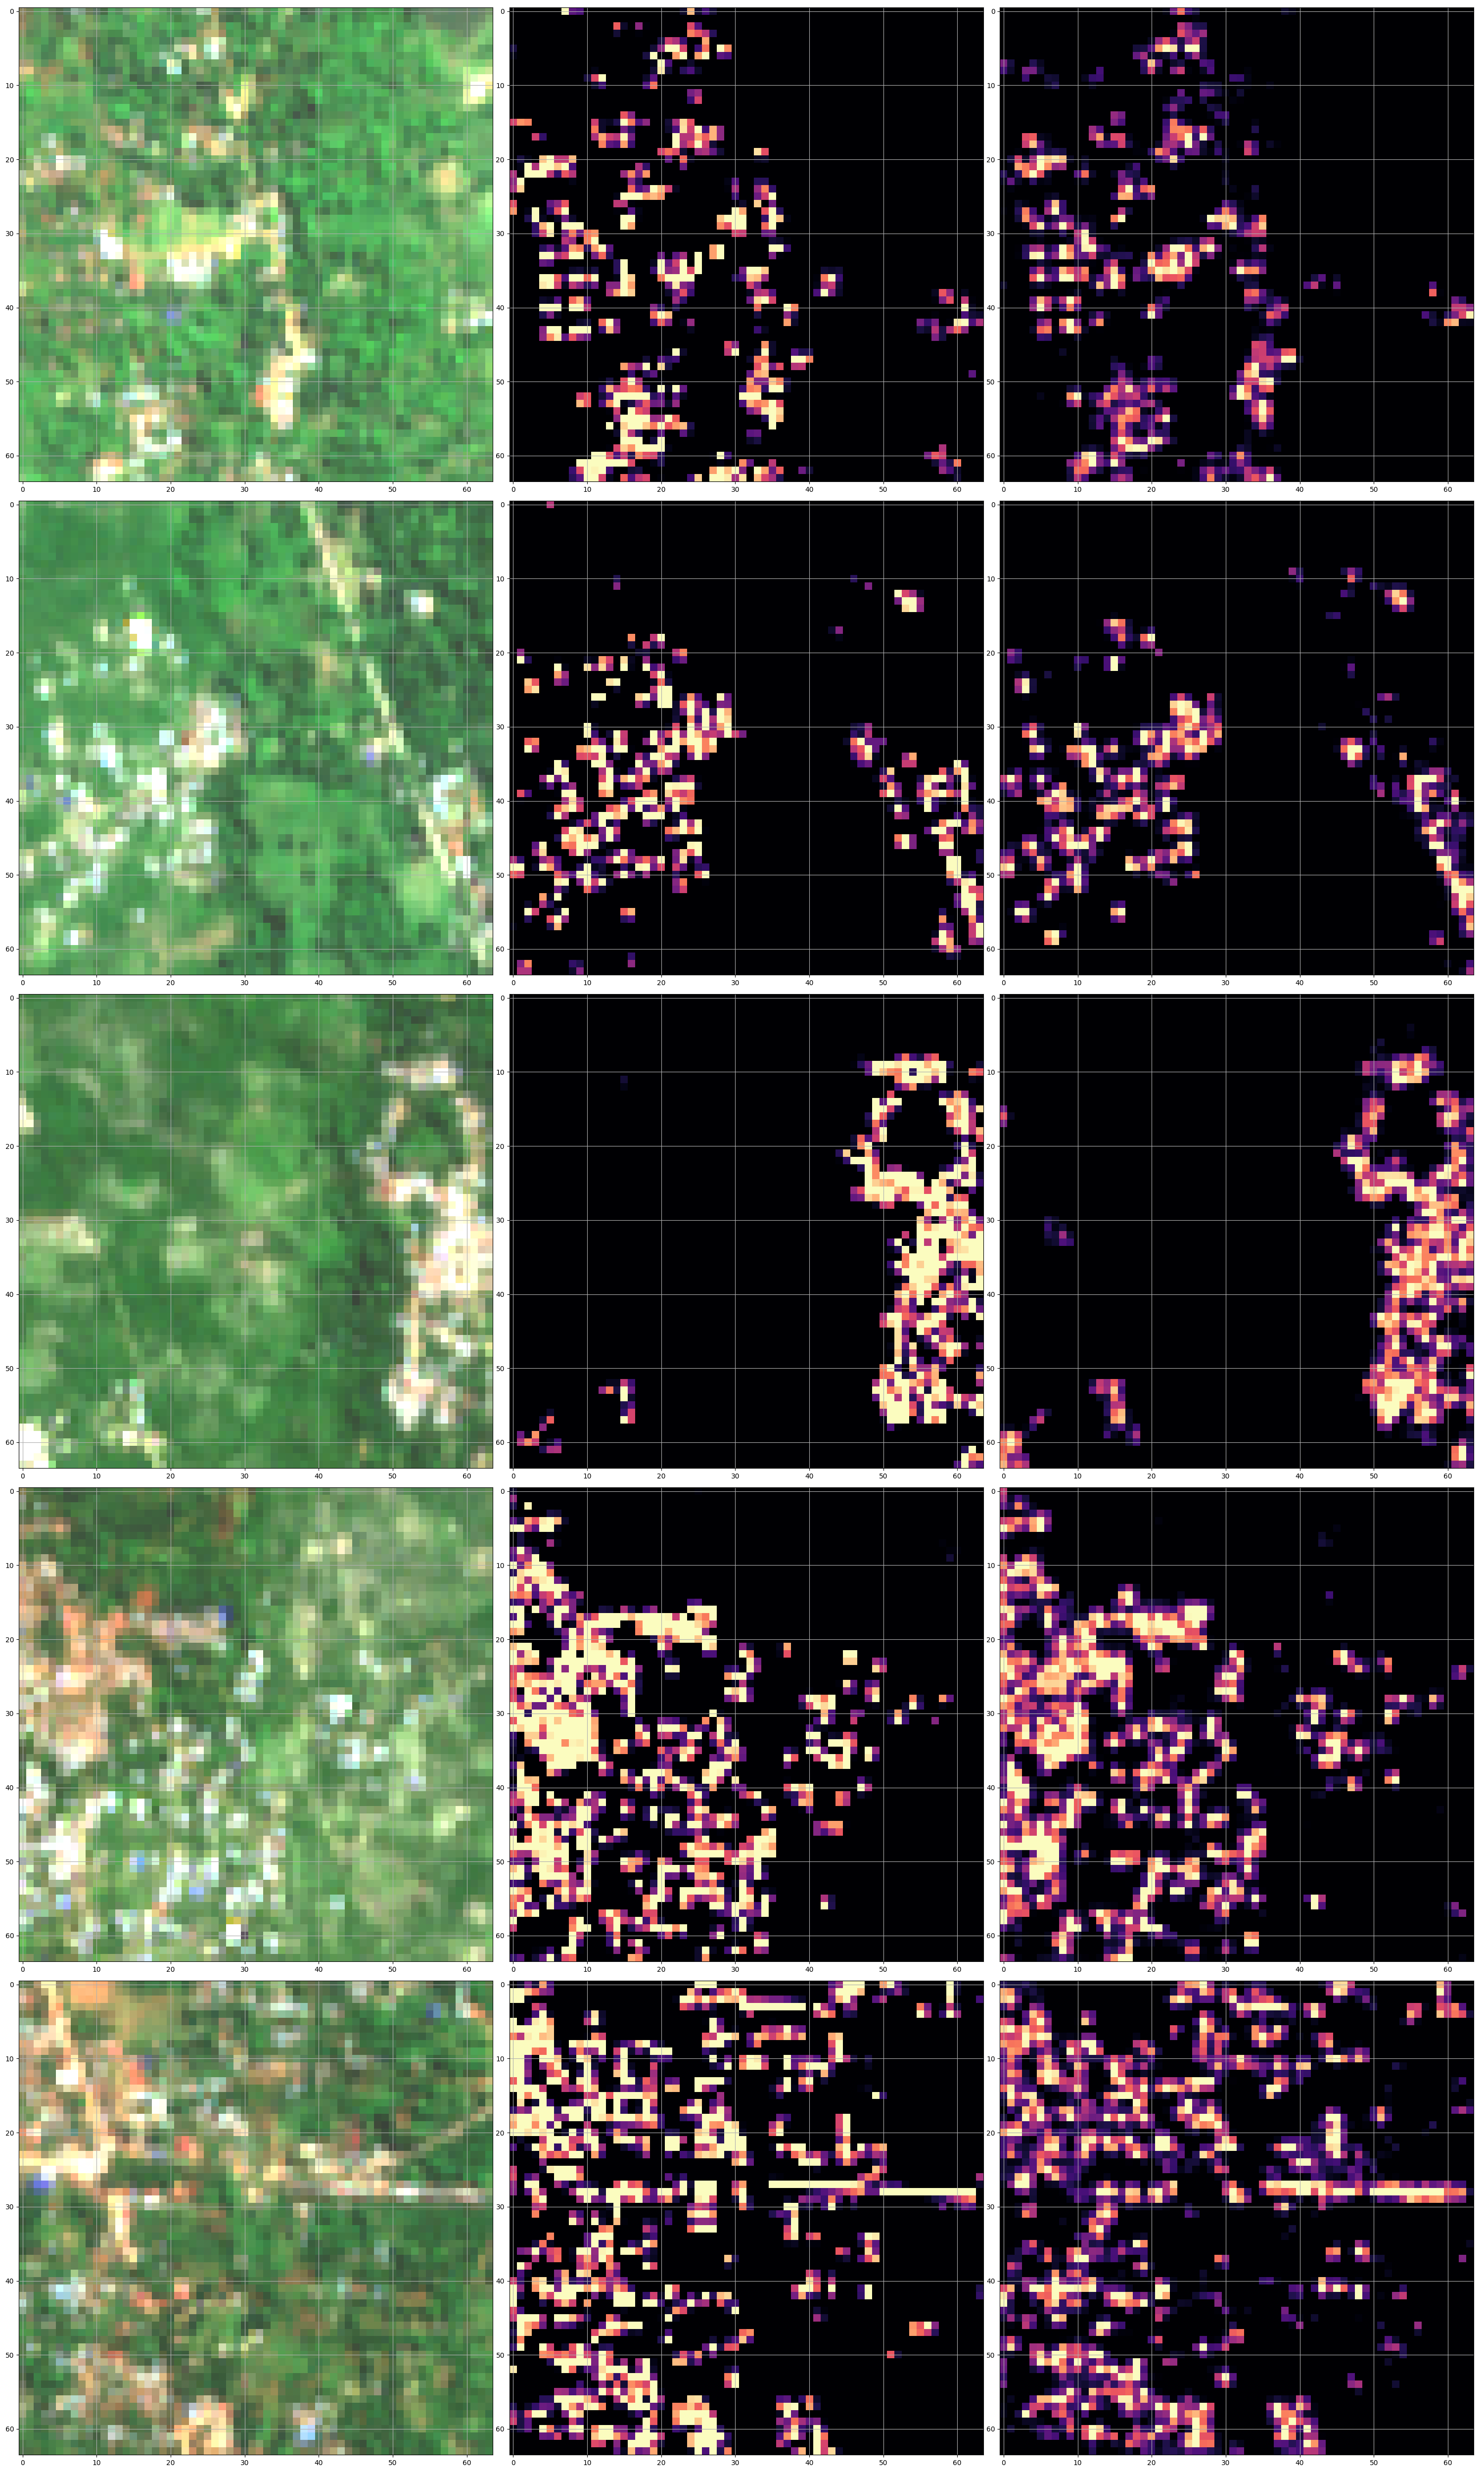

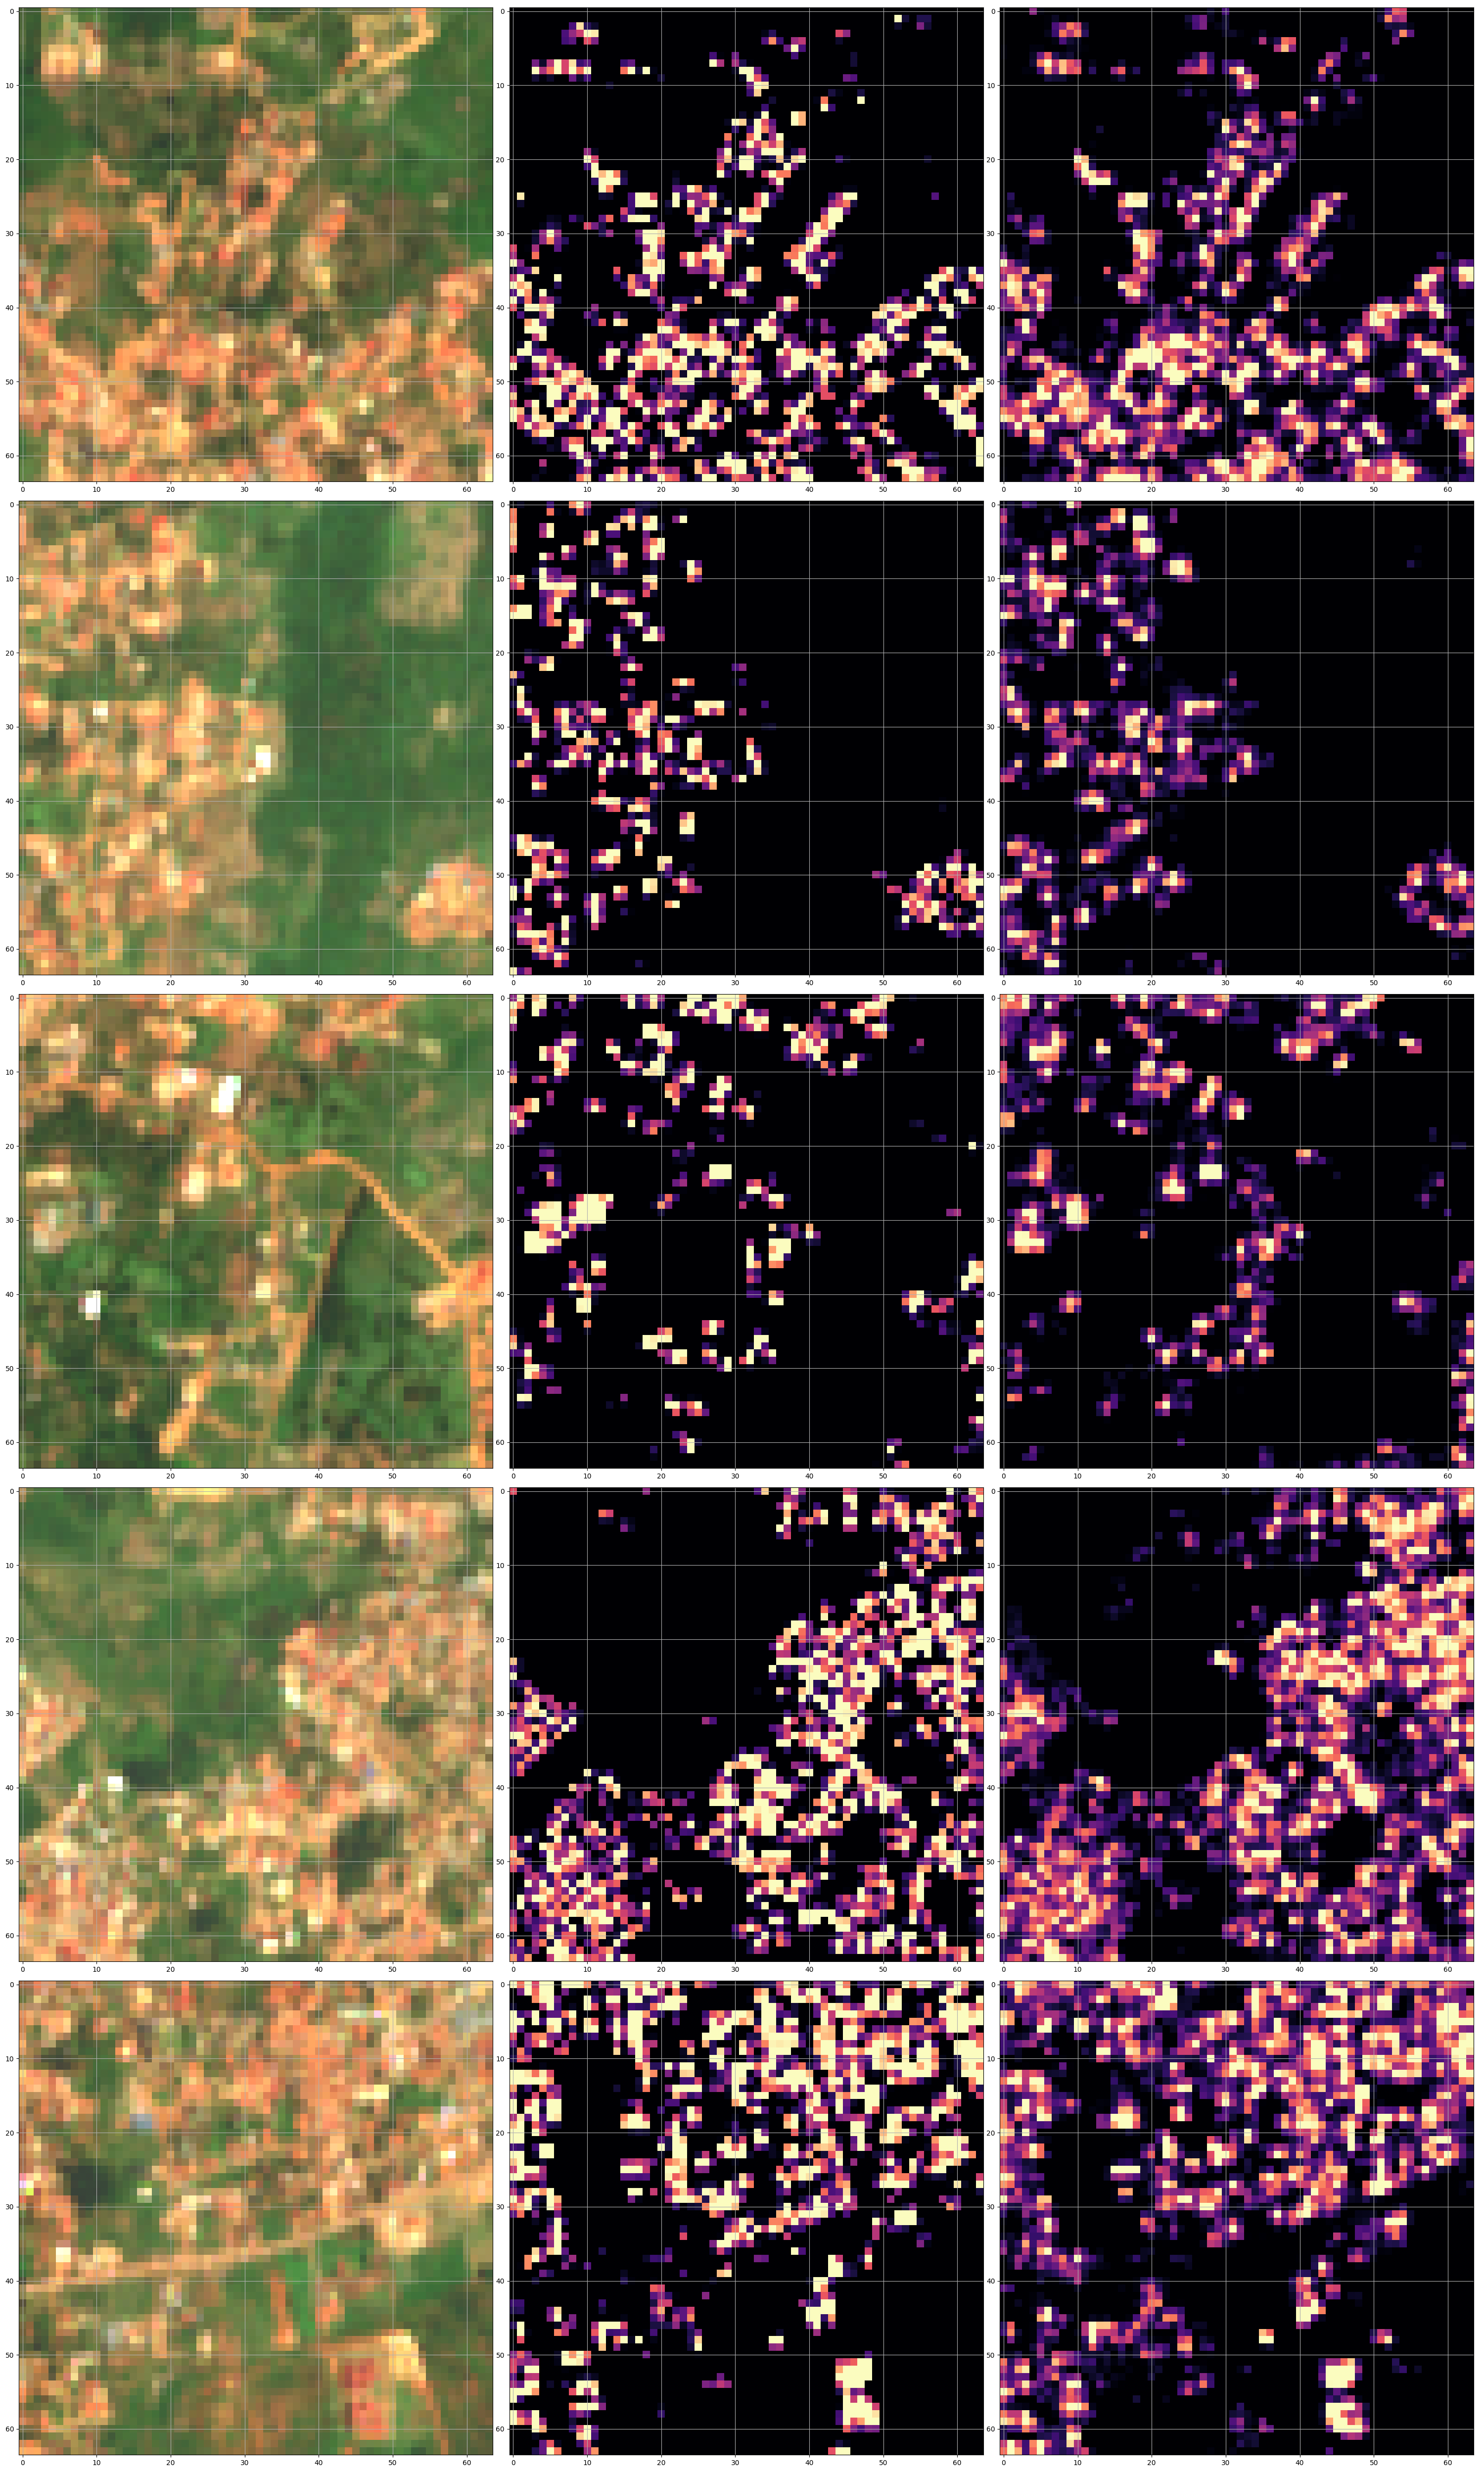

In [29]:
REGIONS_BUILDINGS = ['DNK', 'EGY', 'GHA', 'ISR', 'TZA', 'UGA']
for region in REGIONS_BUILDINGS:
    display(Image(filename= f"{OUTPUT_FOLDER}/visualisations/test_{region}.png"))